# Analise de Jogos mais Jogados da Steam
---

## Integrantes:
- Samuel Santos;
- Pedro Henrique;
- Leonardo Filho;
- Sean Lucas.

---

## Introdução:

---

## Dados Usados:

---
## Importações para Pré-processamento e Analises:

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import linregress

---

## Pré-processamento:

### Formatando Datas de Lançamentos dos Jogos
Como as datas de lançamentos de cada jogo veio no formato "mes-escrito dia, ano", seria inviável utilizarmos esses dados para análise. Portanto, convertemos as datas para o formato DateTime para um uso mais viável.

In [15]:
# Formatando data de lançamento dos jogos
df_games_info = pd.read_csv("data/all_games_info.csv")

df_games_info["release_date"] = pd.to_datetime(df_games_info["release_date"])
df_games_info.to_csv("data/all_games_info.csv", index=False)

### Capturando VRAMs
No dataset "all_games_info.csv", há uma coluna chamada "pc_requirements" em que, nela, possui as especificações de GPUs e/ou GPUs necessárias para um bom funcionamento do software. Entretanto, como a coluna não é padronizada, a coleta da VRAM dessas GPUs ajudaria nas análises a serem feitas. 


In [16]:
# padronizando GPUS pelos modelos e VRAM
pattern = r'(?i)\b(?:GB\s*(?P<vram1>\d+)|(?P<vram2>\d+)\s*GB)|\b(?P<sigla>GTX|GT|RTX|RT|NVidia|GeForce|Intel HD|GTS|INTEL HD Graphics|Intel HD Graphics|GTX)\s*(?P<gnum>\d{2,4})\b'

ex = df_games_info["pc_requirements"].str.extract(pattern)

vram = ex["vram1"].fillna(ex["vram2"])

gpu = (ex["sigla"].str.upper().fillna("") + " " + ex["gnum"].fillna("")).str.strip()
gpu = gpu.replace("", np.nan)

df_games_info["gpu_vram"] = vram.where(vram.notna(), gpu)
df_games_info.loc[vram.notna(), "gpu_vram"] = df_games_info.loc[vram.notna(), "gpu_vram"]


vram_gpus = {
    1: [
        "GTX 550", "GTX 560", "GTX 650", "GT 420", "GTX 470", "GTX 580", "GTX 430", "GTX 260", "GTX 600", "GEFORCE 8800", "GEFORCE 6600", "INTEL HD GRAPHICS 4000", "INTEL HD 3000", "INTEL HD GRAPHICS 520", "NVIDIA 6600", "INTEL HD GRAPHICS 4600"
        "GTX 700", "GT 740", "GTX 460", "GT 430", "GeForce 8800 GT", "GeForce 6600","NVidia 6600", "GeForce 8600", "Intel HD 530", "INTEL HD 4600", "GEFORCE 8600", "INTEL HD 530", "GEFORCE 7300", "NVIDIA 7900", "NVIDIA 9800", "NVIDIA 8600",
        "GEFORCE 6800", "INTEL HD 520"
    ],
    2: [
        "GTX 660", "GTX 680", "GTX 760", "GTX 770", "GT 710", "GT 1030", "GT 450", "GT 730", "GTX 960", "GTX 670", "GTX 1050", "GTX 900", "GTX 750", "Intel HD 4600", "NVidia 650", "GTX 750", "GeForce 760", "GEFORCE 760",
        "GEFORCE 750", "GTS 450",  
    ],
    3: [
        "GTX 780"
    ],
    4: [
        "GTX 1650", "GTX 970", "GTX 980", "GTX 950", "GTX 1070", "GTX 1080", "GTX 1650"
    ],
    6: [
        "GTX 1060"
    ],
    8: [
        "GeForce 1070 Ti", "GEFORCE 1070", "GEFORCE 1080"
    ]
}

for vram, gpus in vram_gpus.items():
    for gpu in gpus:
        if gpu in df_games_info["gpu_vram"].values:
            df_games_info.loc[df_games_info["gpu_vram"] == gpu, "gpu_vram"] = int(vram)
            
df_games_info["gpu_vram"] = df_games_info["gpu_vram"].fillna(1)

df_games_info['gpu_vram'] = pd.to_numeric(df_games_info['gpu_vram'], errors='coerce')
            

            
df_games_info.to_csv("data/all_games_info.csv", index=False)



---
## Perguntas

### 1. Quais jogos se mantiveram no topo ao longo de todos os anos, e o que eles têm em comum?

In [17]:
df_games_fixos = pd.read_csv("data/all_games_info.csv")
df_games_fixos = pd.merge(df_games_fixos, pd.read_csv("data/all_games_review.csv"), on="id", how="outer")
df_games_fixos = pd.merge(df_games_fixos, pd.read_csv("data/all_games_time.csv"), on="id", how="outer")

for i in range(6):
    year = 2019 + i
    
    df_year = pd.read_csv(f"data/most_played_{year}.csv")
    df_games_fixos = pd.merge(df_games_fixos, df_year, on='id', suffixes=(f"_{year-1}", f"_{year}"))
    
df_games_fixos["mean_average"] = df_games_fixos[['average_2019','average_2020','average_2021','average_2022','average_2023','average_2024']].mean(axis=1)
    
    
print("Jogos que se mantiveram no topo entre 2019 e 2024:")
print(df_games_fixos["game"])

Jogos que se mantiveram no topo entre 2019 e 2024:
0                       Team Fortress 2
1                         Left 4 Dead 2
2                                Dota 2
3                      Counter-Strike 2
4              FINAL FANTASY XIV Online
5                              Terraria
6                              PAYDAY 2
7                                  DayZ
8                Euro Truck Simulator 2
9                              Warframe
10                          War Thunder
11                        7 Days to Die
12                                 Rust
13            Grand Theft Auto V Legacy
14         Sid Meier’s Civilization® VI
15                             Unturned
16                Don't Starve Together
17    Tom Clancy's Rainbow Six® Siege X
18                     Dead by Daylight
19                    Hearts of Iron IV
20                       Stardew Valley
21                  PUBG: BATTLEGROUNDS
22                            Destiny 2
Name: game, dtype: object


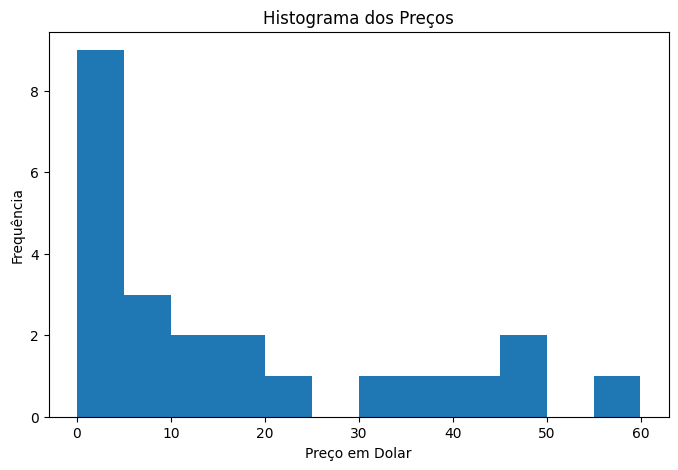

Média: 17.39
Mediana: 9.99
Desvio padrão: 19.47


In [18]:
plt.figure(figsize=(8, 5))
plt.hist(df_games_fixos["price_USD"], bins=12)

plt.title("Histograma dos Preços")
plt.xlabel("Preço em Dolar")
plt.ylabel("Frequência")
plt.show()

print(f"Média: {df_games_fixos["price_USD"].mean():.2f}")
print(f"Mediana: {df_games_fixos["price_USD"].median():.2f}")
print(f"Desvio padrão: {df_games_fixos["price_USD"].std():.2f}")

#### Análise do Histograma dos Preços:
O histograma sugere que os jogos gratuitos são os que mais se mantém no topo.
Também, como a mediana é 9.99, isto significa que 50% dos dados possuem um preço extremamente acessível aos jogadores.

---

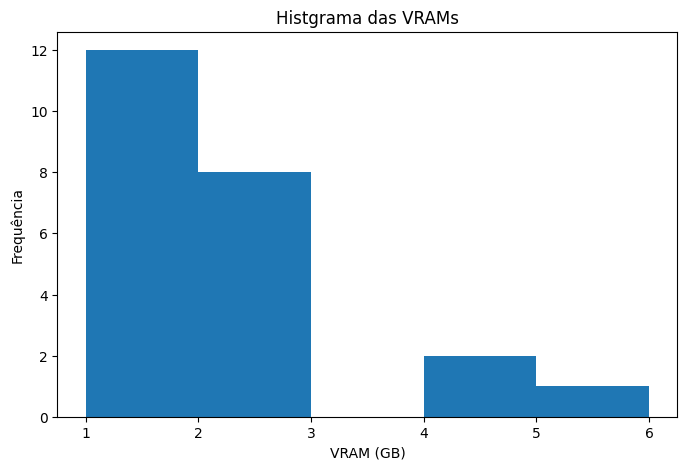

Média: 1.83
Mediana: 1.00
Desvio padrão: 1.27


In [19]:
plt.figure(figsize=(8, 5))
plt.hist(df_games_fixos["gpu_vram"], bins=5)

plt.title("Histgrama das VRAMs")
plt.xlabel("VRAM (GB)")
plt.ylabel("Frequência")
plt.show()

print(f"Média: {df_games_fixos["gpu_vram"].mean():.2f}")
print(f"Mediana: {df_games_fixos["gpu_vram"].median():.2f}")
print(f"Desvio padrão: {df_games_fixos["gpu_vram"].std():.2f}")

#### Análise do Histograma das VRAMs:
O histograma indica que a maioria dos jogos entre os que sempre aparecem nos 6 anos são jogos com requisitos mínimos baixos, o que torna esses jogos de mais fácil acesso ao público geral.

---

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


dados_cluster = df_games_fixos[["price_USD", "gpu_vram", "score", "main_story", "mean_average"]].copy()
dados_cluster = dados_cluster.fillna(dados_cluster.median())

scaler = StandardScaler()
dados_cluster_scl = scaler.fit_transform(dados_cluster)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(dados_cluster_scl)

cluster_labels = kmeans.labels_

df_games_fixos['cluster'] = cluster_labels

perfil_clusters = df_games_fixos.groupby('cluster')[["price_USD", "gpu_vram", "score", "main_story", "mean_average"]].mean().reset_index()
perfil_clusters

,cluster,price_USD,gpu_vram,score,main_story,mean_average
0,0,45.825000,1.500000,7.666667,36.710000,83575.333333
1,1,0.000000,3.000000,5.500000,220.550000,219934.343750
2,2,11.356364,1.727273,8.454545,39.961818,56158.621212
3,3,0.000000,1.000000,8.000000,446.520000,933970.020833


<Figure size 1200x1200 with 0 Axes>

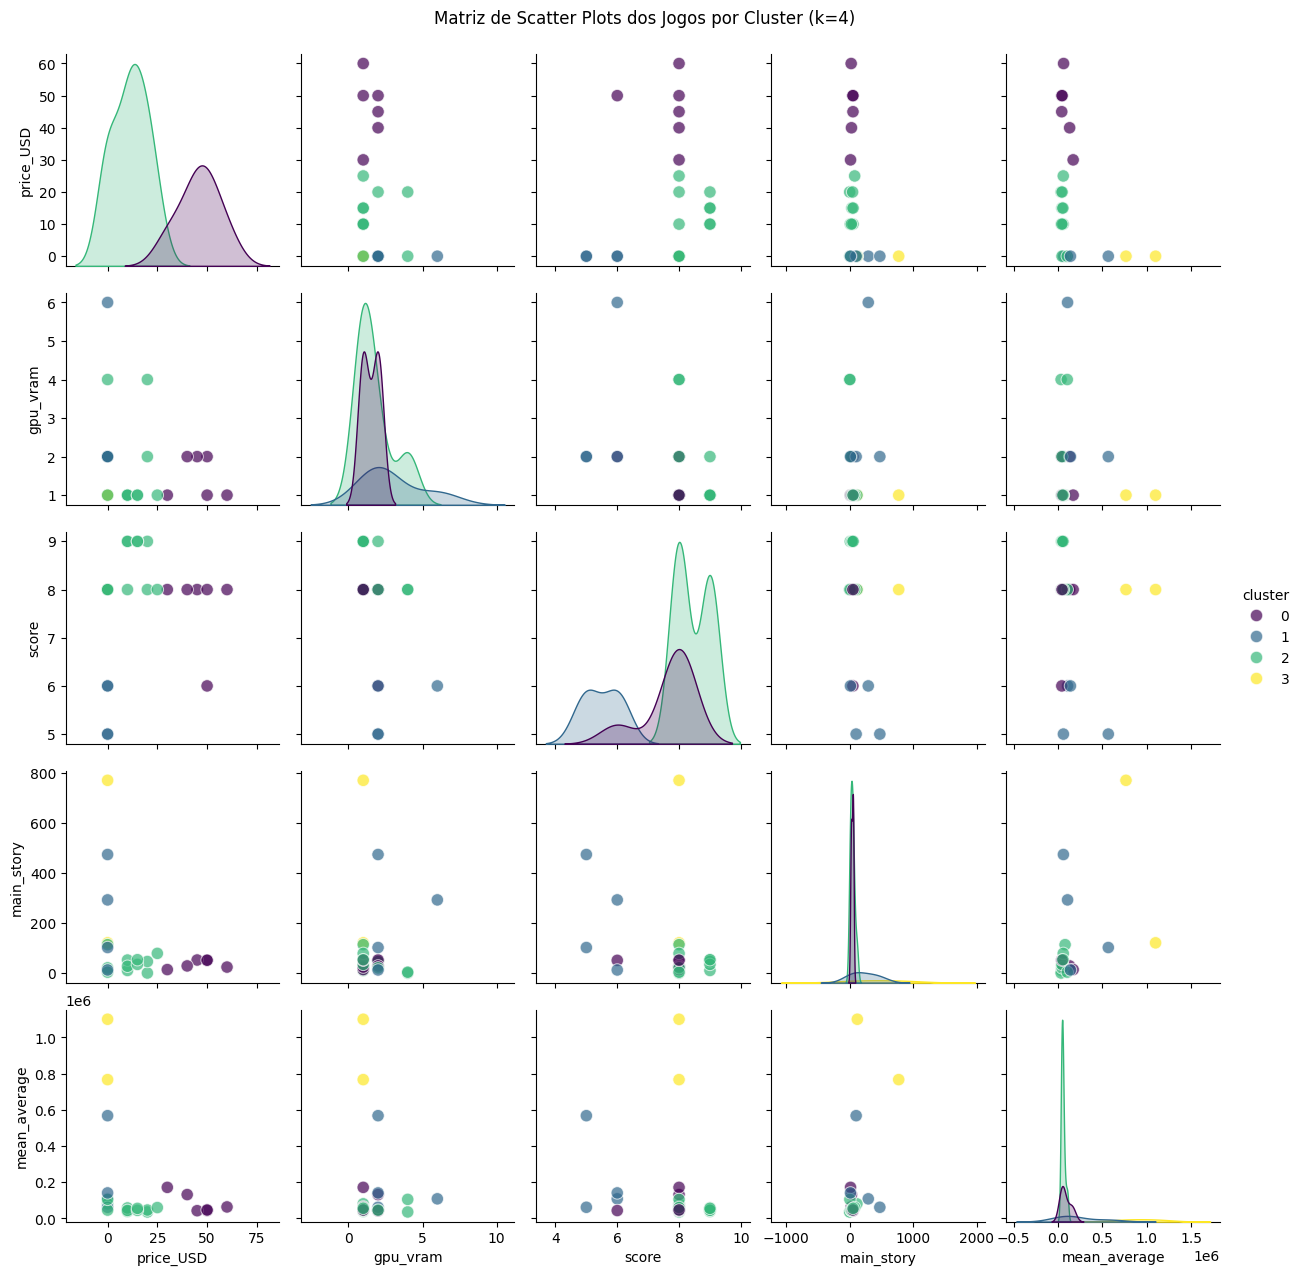

In [21]:
import seaborn as sns

cols_para_pairplot = ["price_USD", "gpu_vram", "score", "main_story", "mean_average"] + ['cluster']

plt.figure(figsize=(12, 12))

sns.pairplot(
    data=df_games_fixos,
    vars=["price_USD", "gpu_vram", "score", "main_story", "mean_average"], 
    hue='cluster',  
    palette='viridis',             
    diag_kind='kde',      
    plot_kws={'alpha': 0.7, 's': 80} 
)

plt.suptitle('Matriz de Scatter Plots dos Jogos por Cluster (k=4)', y=1.02) 
plt.show()

In [22]:
grupo_0 = df_games_fixos["game"].where(df_games_fixos["cluster"] == 0).dropna()
grupo_1 = df_games_fixos["game"].where(df_games_fixos["cluster"] == 1).dropna()
grupo_2 = df_games_fixos["game"].where(df_games_fixos["cluster"] == 2).dropna()
grupo_3 = df_games_fixos["game"].where(df_games_fixos["cluster"] == 3).dropna()


In [23]:
print("GRUPO 0:")
print(grupo_0)

print("--------------------------------------------|")
print("GRUPO 1:")
print(grupo_1)

GRUPO 0:
7                             DayZ
11                   7 Days to Die
12                            Rust
13       Grand Theft Auto V Legacy
14    Sid Meier’s Civilization® VI
19               Hearts of Iron IV
Name: game, dtype: object
--------------------------------------------|
GRUPO 1:
0         Team Fortress 2
10            War Thunder
21    PUBG: BATTLEGROUNDS
22              Destiny 2
Name: game, dtype: object


In [24]:
print("--------------------------------------------|")
print("GRUPO 2:")
print(grupo_2)

print("--------------------------------------------|")
print("GRUPO 3:")
print(grupo_3)

--------------------------------------------|
GRUPO 2:
1                         Left 4 Dead 2
4              FINAL FANTASY XIV Online
5                              Terraria
6                              PAYDAY 2
8                Euro Truck Simulator 2
9                              Warframe
15                             Unturned
16                Don't Starve Together
17    Tom Clancy's Rainbow Six® Siege X
18                     Dead by Daylight
20                       Stardew Valley
Name: game, dtype: object
--------------------------------------------|
GRUPO 3:
2              Dota 2
3    Counter-Strike 2
Name: game, dtype: object


#### Análise do Agrupamento
- Grupo 0: representa jogos com a média dos preços dos jogos mais alta, porém, com a menor média do número de horas jogadas;
- Grupo 1: representa jogos Free To Play que possuem a média das notas baixo, entretando com os maiores requisitos mínimos;
- Grupo 2: representa jogos com preços acessíveis, porém, possuem a média das notas mais altas e o menor número de jogadores;
- Grupo 3: representa jogos Free To Play que possuem o maior número de jogadores e maior tempo de jogo.

### 1. O valor dos jogos influenciam em sua popularidade ?

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob 

arquivos = glob.glob("data/most_played_*.csv")

dfs=[]

dfs = [pd.read_csv(arquivo) for arquivo in arquivos]

picos = pd.concat(dfs, ignore_index=True)

picos_unicos = picos.groupby("id", as_index=False)["peak"].mean()
df_games_info = pd.read_csv("data/all_games_info.csv")

df_final=pd.merge(df_games_info, picos_unicos, on="id", how="left")

df_final.to_csv("data/games_com_pico.csv", index=False)

#Ordena agora os jogos pelo media do pico de jogadores durante o ano
df_final_ordenado = df_final.sort_values(by="peak", ascending=False)
df_final_ordenado = df_final_ordenado.reset_index(drop=True)

df_final=df_final_ordenado
print("Todos os jogos com o preço e o pico")
print(df_final_ordenado[["id", "price_USD","peak"]])





Todos os jogos com o preço e o pico
          id  price_USD          peak
0    2358720      59.99  2.406967e+06
1    1623730      29.99  2.101535e+06
2        730       0.00  1.323927e+06
3        570       0.00  9.047697e+05
4     578080       0.00  7.650387e+05
..       ...        ...           ...
270   606880      34.99  1.619000e+04
271   848450      29.99  1.563700e+04
272   304390      29.99  1.552900e+04
273   492720      39.99  1.517000e+04
274   201270      29.99  1.170000e+02

[275 rows x 3 columns]


### Análise do gráfico de dispersao:
1. A grande maioria dos jogos com altos picos de jogadores são gratuitos, porém, quando se olha para os valores mais altos do gráfico, eles se referem a jogos pagos isso nos mostra que o fator preço zero é muito forte, porém a sua popularidade depende também de outros fatores, como os jogos AAA, blockbusters,que são jogos de "Prrimeira Pratelheira", ou jogos com um hype e qualidade que transcendem o preço. Esses jogos atingem o topo da popularidade apesar do preço, impulsionados por campanhas de marketing maciças e comunidades dedicadas que acaba implicando em uma correlação fraca, 


--- Popularidade Média e Mediana por Faixa de Preço ---
| Faixa_Preço                    | Media_Popularidade   | Mediana_Popularidade   | Contagem_Jogos   |
|:-------------------------------|:---------------------|:-----------------------|:-----------------|
| Grátis/Muito Barato ($0-$4.99) | 171190               | 84175.5                | 65               |
| Médio ($20-$59.99)             | 120661               | 65184.1                | 140              |
| Caro (>$60)                    | 96286.2              | 80396                  | 16               |
| Baixo ($5-$19.99)              | 66361.4              | 57764.2                | 54               |


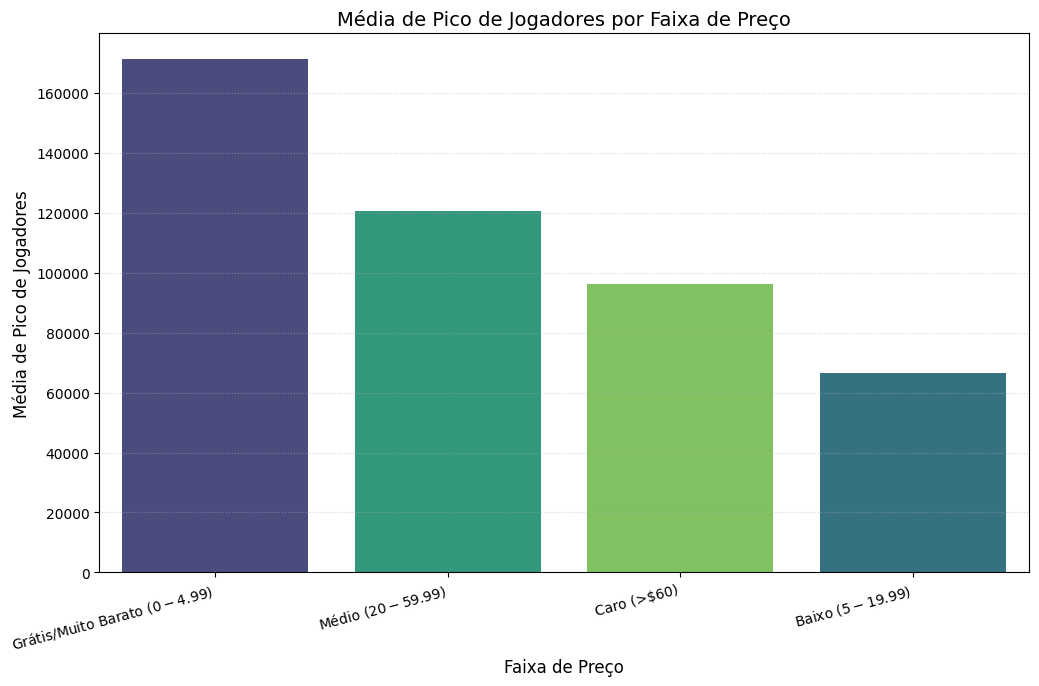

In [26]:
COLUNA_PRECO = 'price_USD'
COLUNA_POPULARIDADE = 'peak'


max_price = df_final[COLUNA_PRECO].max()

# Definindo Bins (Exemplo em USD: 0, 5, 20, 60, >60)
bins_preço = [0, 5, 20, 60, max_price + 1]
labels_preço = ['Grátis/Muito Barato ($0-$4.99)', 'Baixo ($5-$19.99)', 'Médio ($20-$59.99)', 'Caro (>$60)']

df_final['Faixa_Preço'] = pd.cut(
    df_final[COLUNA_PRECO],
    bins=bins_preço,
    labels=labels_preço,
    right=False
)

analise_agrupada = df_final.groupby('Faixa_Preço', observed=False)[COLUNA_POPULARIDADE].agg(
    Media_Popularidade = 'mean',
    Mediana_Popularidade = 'median',
    Contagem_Jogos = 'count'
).reset_index()


print("\n--- Popularidade Média e Mediana por Faixa de Preço ---")
print(analise_agrupada.sort_values(by='Media_Popularidade', ascending=False).to_markdown(index=False, numalign="left", stralign="left"))


plt.figure(figsize=(12, 7))

sns.barplot(
    x='Faixa_Preço',
    y='Media_Popularidade',
    data=analise_agrupada,
    palette='viridis',
    hue='Faixa_Preço', 
    legend=False,  
    order=analise_agrupada.sort_values('Media_Popularidade', ascending=False)['Faixa_Preço']
)

plt.title('Média de Pico de Jogadores por Faixa de Preço', fontsize=14)
plt.xlabel('Faixa de Preço', fontsize=12)
plt.ylabel('Média de Pico de Jogadores', fontsize=12)
plt.xticks(rotation=15, ha='right') # Rotaciona rótulos para melhor leitura
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

### Análise final 
Sim, o preço dos jogos influencia significativamente na sua popularidade,mas de uma forma não-linear e com dinâmicas distintas entre as faixas de preço.

1. A correlação linear é muito fraca (ρ≈−0.08), indicando que o preço, por si só, não prevê a popularidade de forma constante e direta.

2. Analisando por faixa de preço:
     É evidente que a faixa de preço "Grátis/Muito Barato" tem a maior media de todas as faixas, embora tenha menos jogos que a faixa "Médio", confirmando que a de fato os jogos mais jogados se encontra na região onde os preços sao 0 ou muito barato. Quando olhamos pra faixa "Caro", confirmamos a presença dos blockbusters que apesar de sua média e media estarem altas, so teve apenas 7 jogos.